In [68]:
import pandas as pd
import numpy as np
from iou import intersection_over_union
import torch
from matplotlib import pyplot as plt
import numpy as np

Читаю csv-файлы в датафреймы и изучаю как выглядят данные

In [69]:
gt = pd.read_csv('full_dataset/groundtruth.csv')
preds = pd.read_csv('full_dataset/predictions.csv')

In [70]:
preds

clip_name  frame_num     obj_type    x    y    w    h  \
0        evzero blades OO9454.mp4          4    Cellphone  200  270   38   46   
1        evzero blades OO9454.mp4          4   SeatbeltNo  248  203  190  157   
2        evzero blades OO9454.mp4          4         Eyes  267   92   87   43   
3        evzero blades OO9454.mp4          4        Mouth  268  134   87   43   
4        evzero blades OO9454.mp4          4         Face  272   66   76  122   
...                           ...        ...          ...  ...  ...  ...  ...   
2823382        090508095927_2.mp4       1646      Glasses  333  591  204   93   
2823383        090508095927_2.mp4       1647  SeatbeltYes  321  720  396  357   
2823384        090508095927_2.mp4       1647        Mouth  333  675  168   84   
2823385        090508095927_2.mp4       1647         Face  333  534  189  237   
2823386        090508095927_2.mp4       1647      Glasses  333  588  204   99   

         confidence  
0          0.610414  
1          0.984375  
2          0.003906  
3          0.003906  
4          0.000000  
...             ...  
2823382    0.709576  
2823383    0.996094  
2823384    0.003906  
2823385    0.000000  
2823386    0.697394  

[2823387 rows x 8 columns]

In [71]:
gt

clip_name  frame_num  \
0        How Expensive are Good Sunglasses 25- 400 w En...         91   
1        How Expensive are Good Sunglasses 25- 400 w En...         91   
2        How Expensive are Good Sunglasses 25- 400 w En...         91   
3        How Expensive are Good Sunglasses 25- 400 w En...         91   
4        How Expensive are Good Sunglasses 25- 400 w En...         92   
...                                                    ...        ...   
1630713                                 090605150612_2.mp4       1646   
1630714                                 090605150612_2.mp4       1647   
1630715                                 090605150612_2.mp4       1647   
1630716                                 090605150612_2.mp4       1647   
1630717                                 090605150612_2.mp4       1647   

           obj_type    x    y    w    h     label  
0              Face  519   10  248  357  Straight  
1        Sunglasses  531  155  226   80    OnEyes  
2              Eyes  547  150  194   63   Unknown  
3             Mouth  594  269  107   45     Close  
4              Face  519   10  248  357  Straight  
...             ...  ...  ...  ...  ...       ...  
1630713       Mouth  457  618   74   81      Open  
1630714     Glasses  424  517  217   51      Open  
1630715        Face  435  391  225  349  Straight  
1630716        Eyes  447  504  124   51      Open  
1630717       Mouth  458  623   72   78      Open  

[1630718 rows x 8 columns]

In [73]:
gt[gt['obj_type'] == 'Face']['label'].value_counts()

Straight    313981
Unknown      44940
Side         44635
Down         13856
Up            8760
Name: label, dtype: int64

In [74]:
gt['obj_type'].value_counts()

Face          426172
Eyes          414440
Mouth         398239
Glasses       164829
Sunglasses    142460
Cellphone      84578
Name: obj_type, dtype: int64

In [75]:
preds['obj_type'].value_counts()

Face           716255
Mouth          629795
SeatbeltNo     594729
Sunglasses     223908
Eyes           208835
Cellphone      172834
Glasses        172302
SeatbeltYes    104729
Name: obj_type, dtype: int64

In [76]:
obj_types = gt['obj_type'].unique()

In [77]:
preds = preds[preds['obj_type'].isin(obj_types)]

In [78]:
preds['obj_type'].value_counts()

Face          716255
Mouth         629795
Sunglasses    223908
Eyes          208835
Cellphone     172834
Glasses       172302
Name: obj_type, dtype: int64

Пример кадра, на котором есть метки, которые модель не распознала (False Negative)

In [80]:
gt.loc[(gt['clip_name'] == '20191216_123222.mp4') & (gt['frame_num'] == 3592)]

clip_name  frame_num   obj_type    x    y    w    h    label
374878  20191216_123222.mp4       3592       Face  195  278  190  245  Unknown
374879  20191216_123222.mp4       3592    Glasses  213  400  156   60  Unknown
374880  20191216_123222.mp4       3592       Eyes  235  412  117   35  Unknown
374881  20191216_123222.mp4       3592      Mouth  269  480   56   25    Close
374882  20191216_123222.mp4       3592  Cellphone  300  700   84   20     Hard

In [81]:
preds.loc[(preds['clip_name'] == '20191216_123222.mp4') & (preds['frame_num'] == 3592)]

clip_name  frame_num obj_type    x    y    w    h  confidence
47480  20191216_123222.mp4       3592  Glasses  224  402  146   62    0.769557
47481  20191216_123222.mp4       3592     Face  230  368  126  160    0.000000
47482  20191216_123222.mp4       3592    Mouth  238  464  114   56    0.003906

Пример кадра, на котором модель ложно распознала метки, которых нет (False Positive)

In [82]:
gt.loc[(gt['clip_name'] == '20191216_123222.mp4') & (gt['frame_num'] == 68)]

clip_name  frame_num obj_type    x    y    w    h    label
363195  20191216_123222.mp4         68     Face  163  280  235  202     Side
363196  20191216_123222.mp4         68    Mouth  177  434   22   23    Close
363197  20191216_123222.mp4         68     Eyes  185  371   33   32  Unknown

In [83]:
preds.loc[(preds['clip_name'] == '20191216_123222.mp4') & (preds['frame_num'] == 68)]

clip_name  frame_num   obj_type    x    y    w    h  \
33190  20191216_123222.mp4         68      Mouth  140  416  100   50   
33191  20191216_123222.mp4         68       Eyes  144  364  100   50   
33193  20191216_123222.mp4         68       Face  170  340   96  142   
33194  20191216_123222.mp4         68  Cellphone  224  546  138   72   

       confidence  
33190    0.003906  
33191    0.312500  
33193    0.000000  
33194    0.552914

In [84]:
preds.loc[(preds['clip_name'] == '20191216_123222.mp4') & (preds['obj_type'] == 'Cellphone')]

clip_name  frame_num   obj_type    x    y    w    h  \
33194  20191216_123222.mp4         68  Cellphone  224  546  138   72   
33203  20191216_123222.mp4         70  Cellphone  222  542  142   68   
33345  20191216_123222.mp4        106  Cellphone  222  548  136   56   
33350  20191216_123222.mp4        107  Cellphone  220  546  134   62   
33355  20191216_123222.mp4        108  Cellphone  228  544  132   60   
...                    ...        ...        ...  ...  ...  ...  ...   
51550  20191216_123222.mp4       4457  Cellphone  202  410   46  106   
51959  20191216_123222.mp4       4559  Cellphone  192  408   54  100   
51964  20191216_123222.mp4       4560  Cellphone  186  412   58  100   
52470  20191216_123222.mp4       4686  Cellphone  236  508  130   74   
52472  20191216_123222.mp4       4687  Cellphone  214  500  144   84   

       confidence  
33194    0.552914  
33203    0.552914  
33345    0.558194  
33350    0.525194  
33355    0.543845  
...           ...  
51550    0.510330  
51959    0.509747  
51964    0.590903  
52470    0.579531  
52472    0.673247  

[757 rows x 8 columns]

Соединяю разметку и предсказания в один датафрейм

In [85]:
df = gt.merge(preds, how='outer', left_on=['clip_name', 'frame_num', 'obj_type'], right_on=['clip_name', 'frame_num', 'obj_type'])

In [86]:
df.loc[(df['clip_name'] == '20191216_123222.mp4') & (df['frame_num'] == 3592)]

clip_name  frame_num   obj_type    x_x    y_x    w_x    h_x  \
374878  20191216_123222.mp4       3592       Face  195.0  278.0  190.0  245.0   
374879  20191216_123222.mp4       3592    Glasses  213.0  400.0  156.0   60.0   
374880  20191216_123222.mp4       3592       Eyes  235.0  412.0  117.0   35.0   
374881  20191216_123222.mp4       3592      Mouth  269.0  480.0   56.0   25.0   
374882  20191216_123222.mp4       3592  Cellphone  300.0  700.0   84.0   20.0   

          label    x_y    y_y    w_y    h_y  confidence  
374878  Unknown  230.0  368.0  126.0  160.0    0.000000  
374879  Unknown  224.0  402.0  146.0   62.0    0.769557  
374880  Unknown    NaN    NaN    NaN    NaN         NaN  
374881    Close  238.0  464.0  114.0   56.0    0.003906  
374882     Hard    NaN    NaN    NaN    NaN         NaN

In [87]:
df.loc[(df['clip_name'] == '20191216_123222.mp4') & (df['frame_num'] == 68)]

clip_name  frame_num   obj_type    x_x    y_x    w_x  \
363195   20191216_123222.mp4         68       Face  163.0  280.0  235.0   
363196   20191216_123222.mp4         68      Mouth  177.0  434.0   22.0   
363197   20191216_123222.mp4         68       Eyes  185.0  371.0   33.0   
1646852  20191216_123222.mp4         68  Cellphone    NaN    NaN    NaN   

           h_x    label    x_y    y_y    w_y    h_y  confidence  
363195   202.0     Side  170.0  340.0   96.0  142.0    0.000000  
363196    23.0    Close  140.0  416.0  100.0   50.0    0.003906  
363197    32.0  Unknown  144.0  364.0  100.0   50.0    0.312500  
1646852    NaN      NaN  224.0  546.0  138.0   72.0    0.552914

In [88]:
df = df.rename(columns={'x_x' : 'x_gt', 'y_x' : 'y_gt', 'w_x' : 'w_gt', 'h_x' : 'h_gt',
                        'x_y' : 'x_pred', 'y_y' : 'y_pred', 'w_y' : 'w_pred', 'h_y' : 'h_pred',})

Заполняю пропуски нулями

In [89]:
df = df.fillna(0)

In [90]:
df

clip_name  frame_num  \
0        How Expensive are Good Sunglasses 25- 400 w En...         91   
1        How Expensive are Good Sunglasses 25- 400 w En...         91   
2        How Expensive are Good Sunglasses 25- 400 w En...         91   
3        How Expensive are Good Sunglasses 25- 400 w En...         91   
4        How Expensive are Good Sunglasses 25- 400 w En...         92   
...                                                    ...        ...   
2659511                                 090508105732_2.mp4       1386   
2659512                                 090508105732_2.mp4       1386   
2659513                                 090508105732_2.mp4       1387   
2659514                                 090508105732_2.mp4       1393   
2659515                                 090508105732_2.mp4       1518   

           obj_type   x_gt   y_gt   w_gt   h_gt     label  x_pred  y_pred  \
0              Face  519.0   10.0  248.0  357.0  Straight   524.0    82.0   
1        Sunglasses  531.0  155.0  226.0   80.0    OnEyes   522.0   148.0   
2              Eyes  547.0  150.0  194.0   63.0   Unknown   528.0   140.0   
3             Mouth  594.0  269.0  107.0   45.0     Close   524.0   246.0   
4              Face  519.0   10.0  248.0  357.0  Straight   526.0    80.0   
...             ...    ...    ...    ...    ...       ...     ...     ...   
2659511  Sunglasses    0.0    0.0    0.0    0.0         0   381.0   516.0   
2659512   Cellphone    0.0    0.0    0.0    0.0         0   417.0   540.0   
2659513  Sunglasses    0.0    0.0    0.0    0.0         0   378.0   519.0   
2659514  Sunglasses    0.0    0.0    0.0    0.0         0   378.0   522.0   
2659515   Cellphone    0.0    0.0    0.0    0.0         0   435.0   561.0   

         w_pred  h_pred  confidence  
0         220.0   296.0    0.000000  
1         248.0    88.0    0.865158  
2         212.0   106.0    0.085938  
3         212.0   106.0    0.003906  
4         220.0   294.0    0.000000  
...         ...     ...         ...  
2659511   186.0    60.0    0.520158  
2659512   204.0   132.0    0.513950  
2659513   183.0    57.0    0.546035  
2659514   168.0    54.0    0.568684  
2659515   159.0   159.0    0.605707  

[2659516 rows x 13 columns]

In [91]:
df['obj_type'].unique()

array(['Face', 'Sunglasses', 'Eyes', 'Mouth', 'Cellphone', 'Glasses'],
      dtype=object)

In [92]:
def mean_average_precision(data: pd.DataFrame, iou_threshold=0.4, plot_curves=False):
    '''Calculates mAP for each type of object based on dataframe'''
    epsilon = 1e-9
    class_list = data['obj_type'].unique()
    APs = {}
    
    #preparing axes for plots
    if plot_curves:
        nrows = int(np.ceil(len(class_list) / 3))
        ncols = 3
        fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))
        for i in range(nrows):
            for j in range(ncols):
                axs[i, j].set_visible(False)
        ax_x = 0
        ax_y = 0
    
    for type in class_list:
        cur_class_df = data[data['obj_type'] == type]
        cur_class_df = cur_class_df.sort_values('confidence', ascending=False)
        num_detections = len(cur_class_df.loc[(cur_class_df['w_pred'] != 0) & (cur_class_df['h_pred'] != 0)])
        num_true_objects = len(cur_class_df.loc[(cur_class_df['w_gt'] != 0) & (cur_class_df['h_gt'] != 0)])
        
        TP = torch.zeros(num_detections)
        FP = torch.zeros(num_detections)
        
        detection_idx = 0
        for index, row in cur_class_df.iterrows():
            if row['w_pred'] != 0 and row['h_pred'] != 0:
                cords_pred = [row['x_pred'], row['y_pred'], row['w_pred'], row['h_pred']]
                cords_gt = [row['x_gt'], row['y_gt'], row['w_gt'], row['h_gt']]
                iou = intersection_over_union(cords_pred, cords_gt)
                if iou >= iou_threshold:
                    TP[detection_idx] = 1
                else:
                    FP[detection_idx] = 1
                
                detection_idx += 1
                
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        
        recalls = TP_cumsum / (num_true_objects + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        recalls = torch.cat((torch.tensor([0]), recalls))
        precisions = torch.cat((torch.tensor([1]), precisions))
        
        APs[type] = float(torch.trapz(precisions, recalls))
        
        if plot_curves:
            #plotting current class AP curve
            axs[ax_x, ax_y].set_visible(True)
            axs[ax_x, ax_y].plot(recalls, precisions, label=f'AP = {round(APs[type], 4)}')
            axs[ax_x, ax_y].set_title(type)
            axs[ax_x, ax_y].legend(loc='upper right')
            axs[ax_x, ax_y].set_xlabel('recall')
            axs[ax_x, ax_y].set_ylabel('precision')
            ax_y += 1
            if ax_y == 3:
                ax_y = 0
                ax_x += 1

    return APs

Подсчет mAP для всего датасета

Face: 0.2554776668548584
Sunglasses: 0.21178151667118073
Eyes: 0.0705743134021759
Mouth: 0.0009461799054406583
Cellphone: 0.4981195330619812
Glasses: 0.8533702492713928


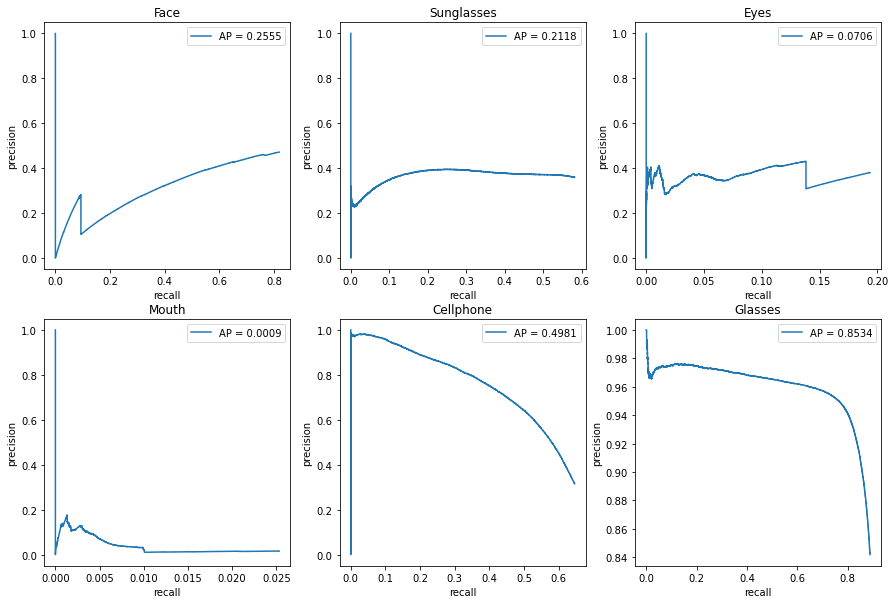

In [96]:
mAP = mean_average_precision(df, iou_threshold=0.4, plot_curves=True)

for type, val in mAP.items():
    print(f'{type}: {val}')

Подсчет mAP для всех сэмплов, где лейбл не "Unknown"

Face: 0.2386123239994049
Sunglasses: 0.27778077125549316
Mouth: 0.0008954039076343179
Eyes: 0.06917884945869446
Cellphone: 0.5414839386940002
Glasses: 0.8927746415138245


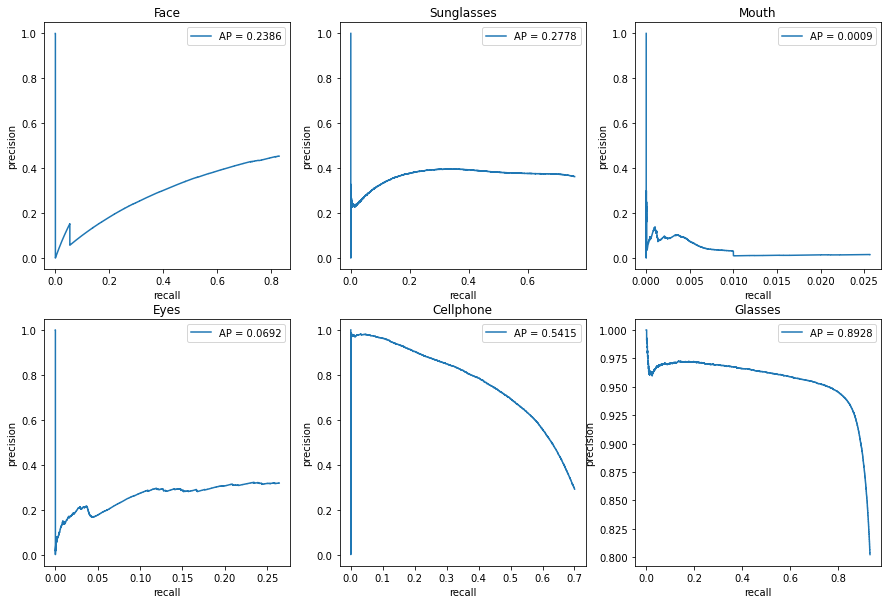

In [97]:
mAP = mean_average_precision(df[df['label'] != 'Unknown'], iou_threshold=0.4, plot_curves=True)

for type, val in mAP.items():
    print(f'{type}: {val}')